<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "4A"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/DissectionRegions/4A/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


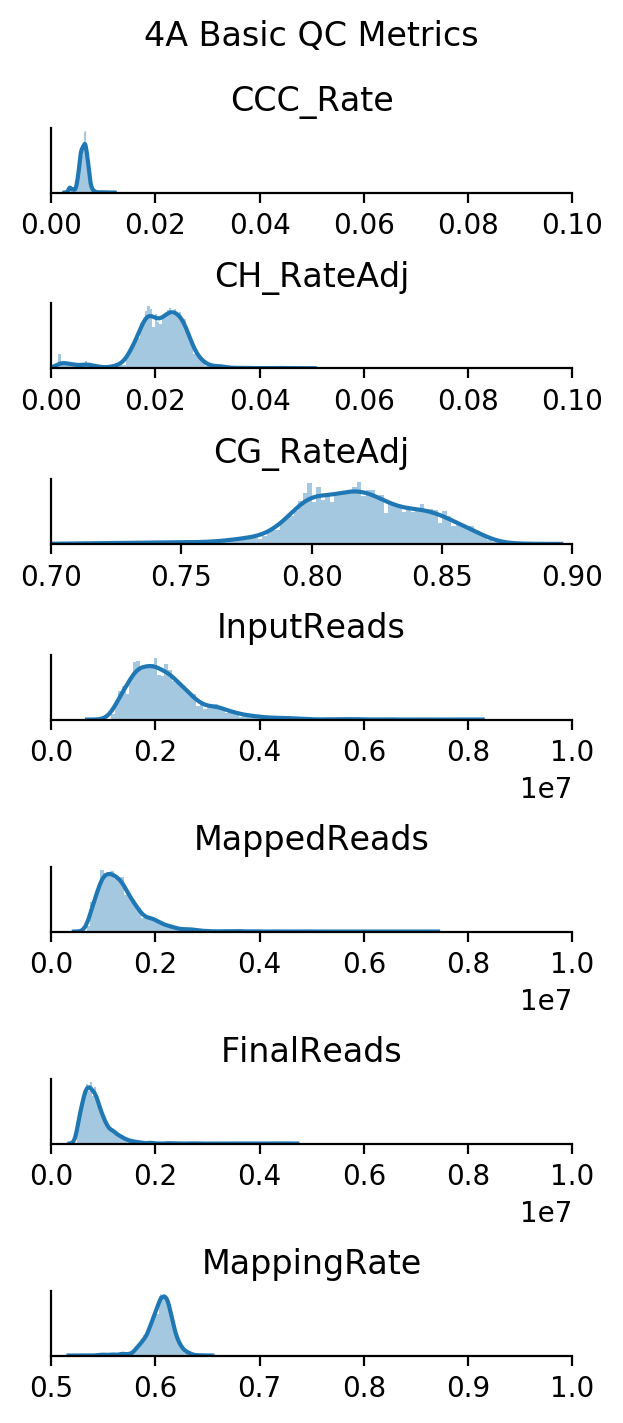

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

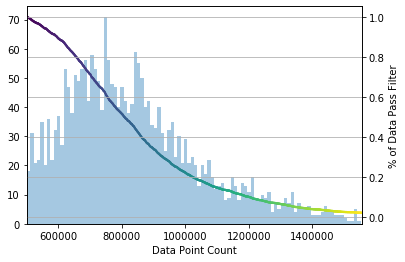

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 2419/2419 (100.0%)
CG_RateAdj passed 2419/2419 (100.0%)
CH_RateAdj passed 2419/2419 (100.0%)
FinalReads passed 2419/2419 (100.0%)
MappingRate passed 2419/2419 (100.0%)
Overall passed 2419/2419 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
180205 1167
180206 1252


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 235 61.2%
ad002 298 77.6%
ad004 319 83.1%
ad006 320 83.3%
ad007 308 80.2%
ad008 316 82.3%
ad010 312 81.2%
ad012 311 81.0%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,SubType,l3-umap_0,l3-umap_1,l3-tsne_0,l3-tsne_1,PassFilter
4A_M_0,/gale/raidix/rdx-4/CEMBA_RS1/4A/CEMBA180205_4A...,0.00656,0.85241,0.85144,0.02995,0.02354,656011.0,1698716,985812.0,4A,...,27.223215,1.315558,-5.413989,-27.343104,NP-L6 Olfml2b,1.916325,-0.509590,5.815351,-15.156962,True
4A_M_1,/gale/raidix/rdx-4/CEMBA_RS1/4A/CEMBA180205_4A...,0.00617,0.80391,0.80269,0.02518,0.01913,718443.0,1833398,1096063.0,4A,...,-25.261866,-17.201490,-8.870186,-55.715888,CGE-Lamp5 Dock5,-2.977514,5.486500,-0.615508,-7.750360,True
4A_M_10,/gale/raidix/rdx-4/CEMBA_RS1/4A/CEMBA180205_4A...,0.00669,0.84424,0.84319,0.02941,0.02287,673422.0,1640040,1012907.0,4A,...,24.960468,7.317886,-18.198442,-18.763248,CT-L6 Tnr,-5.079743,-22.450533,-31.620063,-7.068708,True
4A_M_100,/gale/raidix/rdx-4/CEMBA_RS1/4A/CEMBA180205_4A...,0.00742,0.81940,0.81805,0.03395,0.02673,1167463.0,2928544,1814556.0,4A,...,13.506632,-8.801020,23.395096,-0.065559,IT-L6 Oxr1,-2.088143,1.014116,-22.075257,26.785275,True
4A_M_1000,/gale/raidix/rdx-4/CEMBA_RS1/4A/CEMBA180205_4A...,0.00576,0.79451,0.79332,0.02439,0.01874,759736.0,2041440,1214013.0,4A,...,4.155670,-11.260649,-13.868612,18.119746,IT-L23 Foxp1,-4.696147,-0.622377,-37.267677,10.431768,True
4A_M_1001,/gale/raidix/rdx-4/CEMBA_RS1/4A/CEMBA180205_4A...,0.00615,0.82276,0.82166,0.02723,0.02121,828171.0,2189782,1320545.0,4A,...,7.968569,8.393830,44.349568,9.869945,PT-L5 Unc5b,-18.345003,7.759243,-25.036392,1.942579,True
4A_M_1002,/gale/raidix/rdx-4/CEMBA_RS1/4A/CEMBA180205_4A...,0.00614,0.85094,0.85002,0.02716,0.02115,1102088.0,2868062,1757489.0,4A,...,26.143051,0.271226,-6.631569,-38.405748,NP-L6 Olfml2b,4.855119,-3.235801,10.157650,7.032541,True
4A_M_1003,/gale/raidix/rdx-4/CEMBA_RS1/4A/CEMBA180205_4A...,0.00668,0.86247,0.86155,0.02892,0.02239,1006727.0,2594396,1610224.0,4A,...,27.612034,0.427503,-6.592887,-32.924227,NP-L6 Cntnap5a,3.711794,1.427372,-4.467971,-8.193042,True
4A_M_1004,/gale/raidix/rdx-4/CEMBA_RS1/4A/CEMBA180205_4A...,0.00755,0.82452,0.82319,0.03507,0.02773,1198332.0,3139560,1934718.0,4A,...,10.298704,9.579301,49.744350,25.088523,PT-L5 Tenm2,-11.622176,4.949578,7.722455,2.749016,True
4A_M_1005,/gale/raidix/rdx-4/CEMBA_RS1/4A/CEMBA180205_4A...,0.00551,0.82055,0.81956,0.02321,0.01780,1048695.0,2772978,1697677.0,4A,...,12.749897,-6.921402,22.556596,-11.662458,IT-L6 Fstl4,-10.845225,0.307846,26.715289,23.297492,True
